
# Creating Activation Atlases with captum.optim

This notebook demonstrates the use of the captum.optim submodule for creation of Activation Atlases for the InceptionV1 model imported from Caffe.


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

To create an activation atlas for our model, we need to use the dataset that the model was trained on. In the case of the Inception V1 model, we use the training images from ImageNet's ILSVRC2012 dataset. You can download the dataset from the [ImageNet website](http://image-net.org/challenges/LSVRC/2012/index) or via BitTorrent from [Academic Torrents](https://academictorrents.com/details/a306397ccf9c2ead27155983c254227c0fd938e2).

Due to the size of the dataset, you'll have to download it separately and then load it in a `torch.utils.DataLoader` instance.

In [ ]:
image_dataset = # torch.utils.DataLoader instance with your dataset


Once we have our dataset loaded, we then randomly sample an x and y position in every image for all target layers. It's recommended that you save the sampled activations, as it can be time consuming to capture new activation samples. To randomly sample the activations, we use Captum's `capture_activation_samples` function.

For this tutorial we will be only using the Mixed4c layer as the target, but any number of targets can be used. We also provide a list of target names to use for the output dictionary of activation samples.

In [ ]:
targets = [model.mixed4c]
target_names = ["mixed4c"]
m4c_activation_samples = optimviz.dataset.capture_activation_samples(
    image_dataset, model, targets, target_names, num_samples=100000
)["mixed4c"]

# Saving and loading the activation samples
# torch.save(activation_samples, "activation_samples.pt")
# activation_samples = torch.load("activation_samples.pt")

Now that we have our dataset activation samples for Mixed4c, we can use either UMAP or Sklearn's TSNE to reduce the number of channels to 2. Having only two channels will let us visualize the activations as x and y positions on a graph. Before graphing the reduced activations, we normalize them in order to remove outliers.

UMAP(a=None, angular_rp_forest=True, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='cosine',
     metric_kwds=None, min_dist=0.01, n_components=2, n_epochs=None,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Jan 11 20:08:12 2021 Finding Nearest Neighbors
Mon Jan 11 20:08:12 2021 Building RP forest with 21 trees
Mon Jan 11 20:08:25 2021 NN descent for 17 iterations
	 0  /  17
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	 10  /  17
	 11  /  17
Mon Jan 11 20:10:14 2021 Finished Nearest Neighbor Se

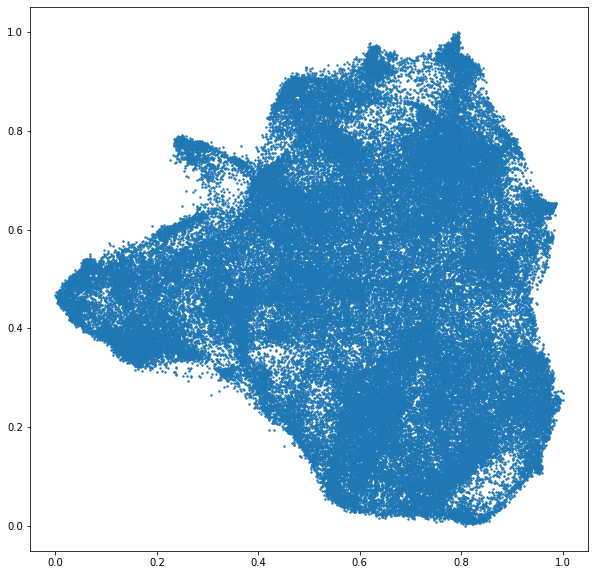

In [7]:
import umap

c_reducer = optimviz.reducer.ChannelReducer(
    n_components=2,
    reduction_alg=umap.UMAP,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
)
# You can also use TSNE instead of UMAP if desired:
# from sklearn.manifold import TSNE
# c_reducer = optimviz.reducer.ChannelReducer(
#    n_components=2,
#    reduction_alg=TSNE,
#    verbose=True,
#    metric="cosine",
#    learning_rate=10,
#    perplexity=50,
# )

umap_m4c = c_reducer.fit_transform(m4c_activation_samples)

# Normalize umap reduced activations for graph
normalized_umap_m4c = optimviz.atlas.normalize_grid(umap_m4c)

# Show the normalized umap reduced activations
plt.figure(figsize=(10, 10))
plt.scatter(x=normalized_umap_m4c[:, 0], y=normalized_umap_m4c[:, 1], s=2)
plt.show()

Now we can use both the raw Mixed4c activations and our dimensionality reduced activations to create the direction vectors for generating visualizations. The `create_atlas_vectors` function will return a set of direction vectors and a list of coordinations for creating the activation atlas image.

In [17]:
vecs, vec_coords = optimviz.atlas.create_atlas_vectors(
    umap_m4c, m4c_activation_samples, grid_size=(40, 40)
)

The default `NeuronDirection` objective can be used, but better results are possible with a special whitened version of the neuron direction objective. Below we define our whitened neuron direction objective (`WhitenedNeuronDirection`) and two helper functions to help us visualize all the atlas vectors that we created above.

In [10]:
from typing import Tuple, Optional
from PIL import Image

class WhitenedNeuronDirection(optimviz.loss.Loss):

    def __init__(
        self,
        target: torch.nn.Module,
        vec: torch.Tensor,
        vec_w: torch.Tensor,
        x: Optional[int] = None,
        y: Optional[int] = None,
    ) -> None:
        super(optimviz.loss.Loss, self).__init__()
        self.target = target
        self.direction = vec.reshape((1, -1))
        self.x = x
        self.y = y
        self.vec_w = vec_w

    def __call__(self, targets_to_values) -> torch.Tensor:
        activations = targets_to_values[self.target]

        assert activations.dim() == 4
        _y = activations.shape[2] // 2 if self.y is None else self.y    
        _x = activations.shape[3] // 2 if self.x is None else self.x
        
        activations = activations[0, :, _x , _y]
        vec = torch.matmul(self.direction[None], self.vec_w)[0]
        return activations * vec


def vis_neuron_direction(model, target, vec: torch.Tensor, vec_w: torch.Tensor) -> torch.Tensor:
    image = optimviz.images.NaturalImage((80, 80)).to(device)
    loss_fn = WhitenedNeuronDirection(target, vec, vec_w)
    transforms = torch.nn.Sequential(
        torch.nn.ConstantPad2d(2, value=1.0),
        optimviz.transform.RandomSpatialJitter(4),
        optimviz.transform.RandomSpatialJitter(4),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomScale(
            scale=[0.995 ** n for n in range(-5, 80)]
            + [0.998 ** n for n in 2 * list(range(20, 40))]
        ),
        optimviz.transform.RandomRotation(
            degrees=list(range(-20, 20))
            + list(range(-10, 10))
            + list(range(-5, 5))
            + 5 * [0]
        ),
        optimviz.transform.RandomSpatialJitter(2),
    )
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128, False))
    return image()._t


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def export(x, filename: str, scale: float = 255.0) -> None:
    """
    Save CHW & NCHW tensors as images.
    """
    if len(x.shape) == 3:
        numpy_thing = x.cpu().detach().numpy().transpose(1, 2, 0) * scale
    elif len(x.shape) == 4:
        numpy_thing = x.cpu().detach().numpy()[0].transpose(1, 2, 0) * scale
    im = Image.fromarray(numpy_thing.astype("uint8"), "RGB")
    im.save(filename)

We whiten the raw Mixed4c activations for the `WhitenedNeuronDirection` objective:

In [11]:
# Whiten the raw activations
whitend_activations_m4c = torch.inverse(
    torch.matmul(m4c_activation_samples.T, m4c_activation_samples)
    / len(m4c_activation_samples)
)

To generate all of the activation atlas images, we'll iterate through all the previously calculated direction vectors. To monitor our progress, we can use the `tqdm` library.

In [12]:
from tqdm import tqdm

A=[]
for i in tqdm(range(vecs.size(0))):
    img = vis_neuron_direction(model, model.mixed4c, vec=vecs[i], vec_w=whitend_activations_m4c)
    A.append(img)

100%|██████████| 271/271 [48:08<00:00, 10.66s/it]


Now we put all the images together using the cell coordinates that we previously calculated!

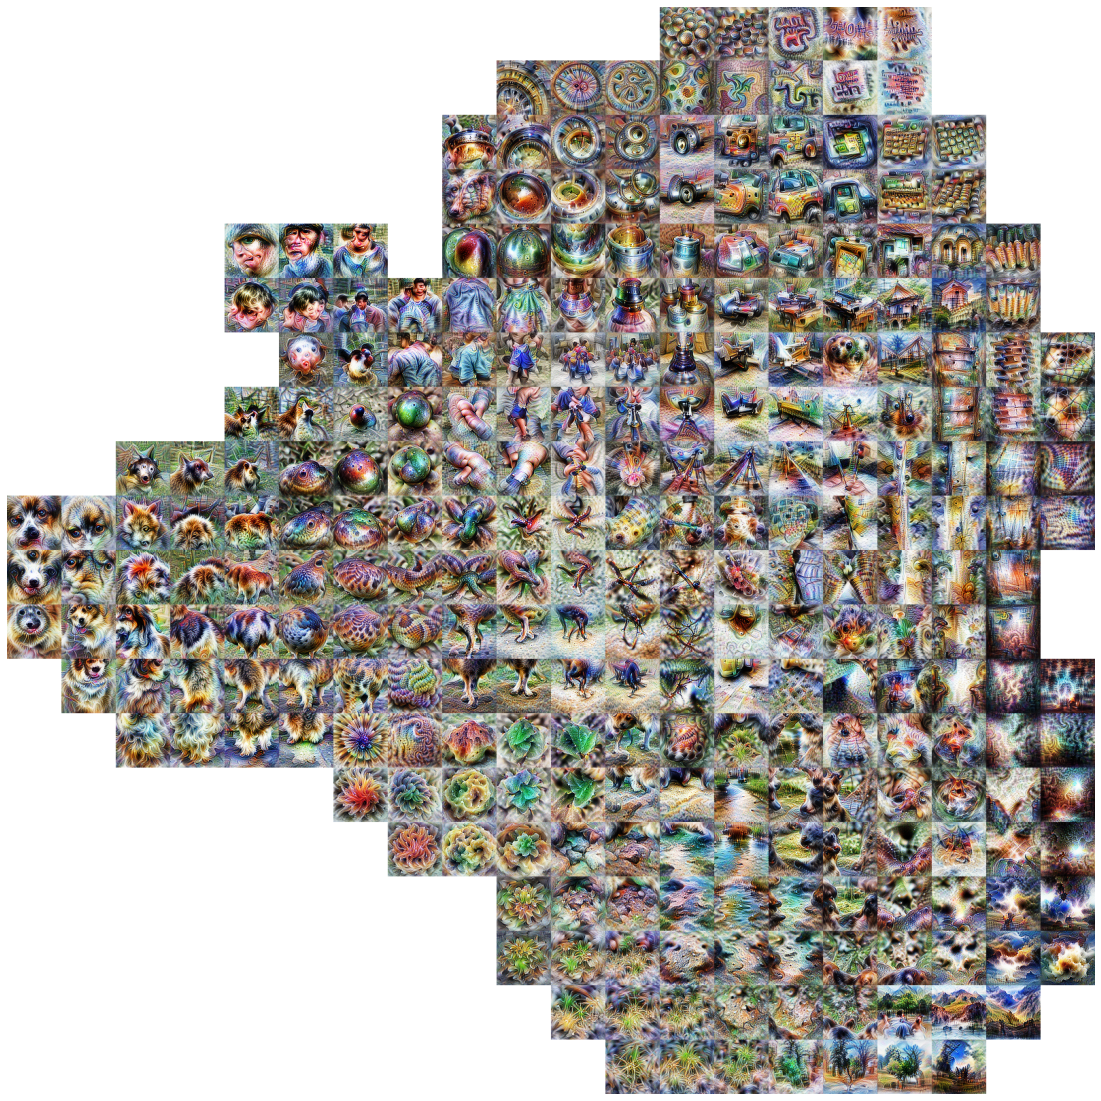

In [13]:
atlas_img = optimviz.atlas.create_atlas(A, vec_coords, grid_size=(20, 20))
export(atlas_img.detach(), "atlas.jpg")
show(atlas_img.detach(), figsize=(20, 20))